# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [225]:
# import libraries
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.feature import StandardScaler, VectorAssembler, Normalizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [137]:
# create a Spark session
spark = SparkSession.builder.appName('Capstone Project').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [138]:
df = spark.read.json('mini_sparkify_event_data.json')
df.createOrReplaceTempView("spark_table")
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [139]:
print((df.count(), len(df.columns)))

(286500, 18)


In [140]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [141]:
# Check for missing values in Level
df.describe('level').show()

+-------+------+
|summary| level|
+-------+------+
|  count|286500|
|   mean|  null|
| stddev|  null|
|    min|  free|
|    max|  paid|
+-------+------+



There are no missing values in the field "level".

In [142]:
# Check for missing values in userId
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



It looks like there are missing values in userId. Lets check the count of missing values and remove these records from the data set.

In [143]:
spark.sql("Select count(1) from spark_table where userId = ''").show()

+--------+
|count(1)|
+--------+
|    8346|
+--------+



In [144]:
# Remove these 8,346 records from the data set
df = df.filter(df['userId']!='')

In [145]:
# check to confirm is there are any more missing values in user id
df.createOrReplaceTempView("spark_table")
spark.sql("Select count(1) from spark_table where (userId = '' or userId is null)").show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [146]:
# Check for distinct users in the data set
spark.sql("select count(distinct userId) as Distinct_User_Count from spark_table").show()

+-------------------+
|Distinct_User_Count|
+-------------------+
|                225|
+-------------------+



In [147]:
# Check for missing values in SessionId
df.describe('sessionId').show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            278154|
|   mean|1042.5616241362698|
| stddev| 726.5010362219813|
|    min|                 1|
|    max|              2474|
+-------+------------------+



There are no nulls / blanks in sessionId

In [148]:
# check the cleaned data set
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

##### Preliminary Data Analysis

In [149]:
#Create a view to perform SQL operations
df.createOrReplaceTempView("spark_table_clean")

In [150]:
# Look at user split based on Gender

gender_count = spark.sql('''
        select gender,count(distinct userId) as Count
        from spark_table_clean
        group by gender
''')
gender_count.show()

+------+-----+
|gender|Count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



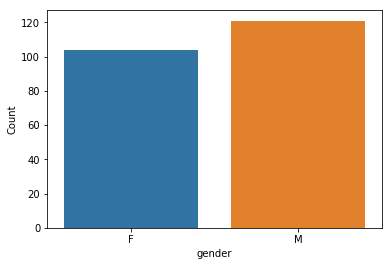

In [151]:
sns.barplot(x='gender',y='Count',data=gender_count.toPandas());

There are more male users in this data set

In [152]:
# Check for values on Auth by user count
auth_count = spark.sql("Select Auth, count(distinct userId) as Count from spark_table_clean group by Auth")
auth_count.show()

+---------+-----+
|     Auth|Count|
+---------+-----+
|Cancelled|   52|
|Logged In|  225|
+---------+-----+



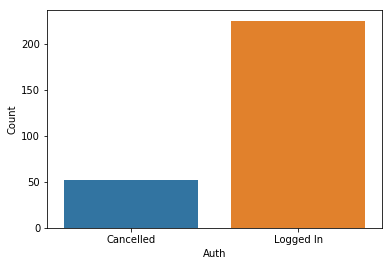

In [153]:
sns.barplot(x='Auth',y='Count',data=auth_count.toPandas());

It looks like out of the 225 users, 52 of them have cancelled the service.

In [154]:
#user count by subscription type (at any point of time)
sub_type = spark.sql('''
        Select level,count(Distinct userId) as Count
        FROM spark_table_clean
        GROUP BY level
''')
sub_type.show()

+-----+-----+
|level|Count|
+-----+-----+
| free|  195|
| paid|  165|
+-----+-----+



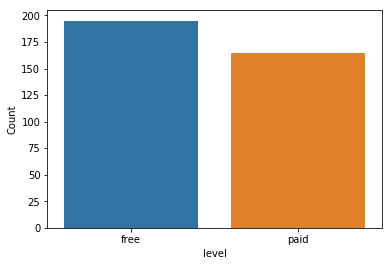

In [155]:
sns.barplot(x='level',y='Count',data=sub_type.toPandas());

In [156]:
# User count by current subscription Type 
sub_type = spark.sql('''
        Select A.level,count(Distinct A.userId) as Count
        FROM spark_table_clean A
        inner join (select UserId,max(ts) as max_ts from spark_table_clean group by userId) B
        on A.userId = B.userId
        and A.ts = B.max_ts
        GROUP BY A.level
''')
sub_type.show()

+-----+-----+
|level|Count|
+-----+-----+
| free|   80|
| paid|  145|
+-----+-----+



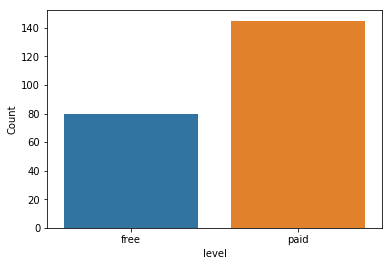

In [157]:
sns.barplot(x='level',y='Count',data=sub_type.toPandas());

At any point in time, the number of users with Paid subscription was 165 and with free subscription was 195. When i looked at the current state (i.e the latest record for each user) it looks like some people have downgraded from Paid to Free over a period of time as the count users with Paid subscription is 145 (reduced from 165).

In [158]:
# Location wise data
loc_count = spark.sql('''
        Select location,count(Distinct userId) as Count
        from spark_table_clean
        group by location
        order by Count Desc
''')
loc_count.show()

+--------------------+-----+
|            location|Count|
+--------------------+-----+
|Los Angeles-Long ...|   16|
|New York-Newark-J...|   15|
|Dallas-Fort Worth...|    7|
|Phoenix-Mesa-Scot...|    7|
|    St. Louis, MO-IL|    6|
|Chicago-Napervill...|    6|
|Charlotte-Concord...|    6|
|Philadelphia-Camd...|    5|
|Miami-Fort Lauder...|    5|
|Boston-Cambridge-...|    5|
|Atlanta-Sandy Spr...|    4|
|Washington-Arling...|    4|
|Houston-The Woodl...|    4|
|San Diego-Carlsba...|    3|
|Las Vegas-Henders...|    3|
|New Haven-Milford...|    3|
|Providence-Warwic...|    2|
|San Antonio-New B...|    2|
|Indianapolis-Carm...|    2|
|         Jackson, MS|    2|
+--------------------+-----+
only showing top 20 rows



Looks like Location field has both City and State information. lets split this into two fields.

In [159]:
# Split location into City & State
df = df.withColumn("City",split(col("location"),",").getItem(0)) \
        .withColumn("State",split(col("location"),",").getItem(1)) \
        .drop("location")

In [160]:
# replace view
df.createOrReplaceTempView("spark_table_clean")

In [161]:
# State Wise count of users
state_count = spark.sql("Select state,count(distinct userId) as Count \
                        from spark_table_clean group by state \
                        order by Count desc")

state_count.show()

+------------+-----+
|       state|Count|
+------------+-----+
|          CA|   33|
|          TX|   16|
|    NY-NJ-PA|   15|
|          FL|   14|
|          AZ|    7|
|          CT|    7|
|    IL-IN-WI|    6|
|       MO-IL|    6|
|       NC-SC|    6|
|          NC|    6|
|          MI|    5|
|          NY|    5|
| PA-NJ-DE-MD|    5|
|       MA-NH|    5|
|          GA|    4|
| DC-VA-MD-WV|    4|
|          CO|    4|
|          WA|    4|
|          AL|    4|
|          NV|    3|
+------------+-----+
only showing top 20 rows



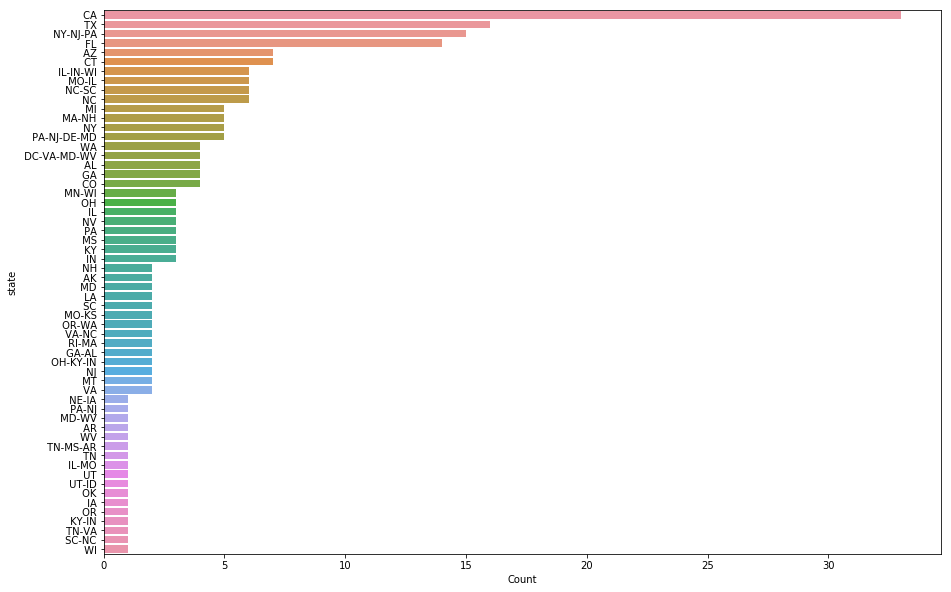

In [162]:
plt.figure(figsize=(15,10))
sns.barplot(x='Count',y='state',data=state_count.toPandas());

California is the clear leader in terms of number of users compared to other states in the dataset

In [163]:
# Split timestamp into Hour, Day and Weekday
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). strftime("%H"))
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). strftime("%d"))
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). strftime("%A"))


In [164]:
df = df.withColumn("hour", get_hour(df.ts)) \
        .withColumn("day", get_day(df.ts)) \
        .withColumn("weekday", get_weekday(df.ts)) \
        .drop("ts")

In [165]:
# Replace view
df.createOrReplaceTempView("spark_table_clean")

In [166]:
#User count by the hour of the day
users_by_hour = spark.sql("Select hour,count(distinct userId) as Count \
                        from spark_table_clean group by hour \
                        order by hour")

users_by_hour.show()

+----+-----+
|hour|Count|
+----+-----+
|  00|  173|
|  01|  172|
|  02|  177|
|  03|  171|
|  04|  172|
|  05|  172|
|  06|  175|
|  07|  174|
|  08|  165|
|  09|  166|
|  10|  170|
|  11|  174|
|  12|  182|
|  13|  187|
|  14|  189|
|  15|  194|
|  16|  189|
|  17|  188|
|  18|  185|
|  19|  184|
+----+-----+
only showing top 20 rows



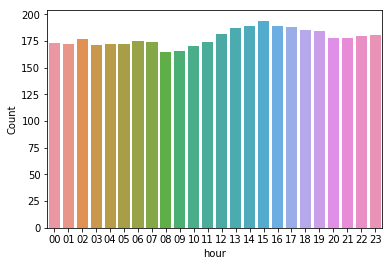

In [167]:
sns.barplot(x='hour',y='Count',data=users_by_hour.toPandas());

users generally seem to be using sparkify more after 13:00 hrs.

In [168]:
#User count by the day of the month
users_by_days = spark.sql("Select day,count(distinct userId) as Count \
                        from spark_table_clean group by day \
                        order by day")

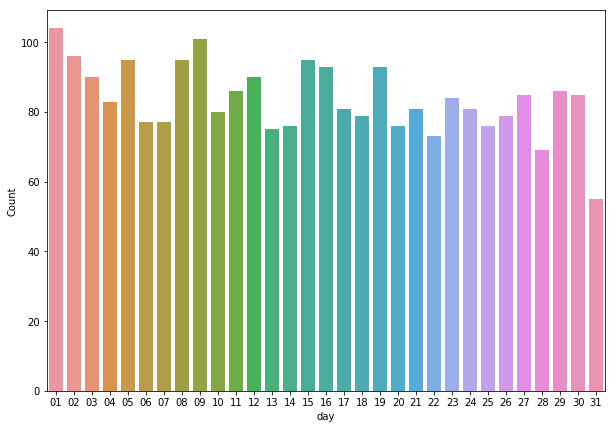

In [169]:
plt.figure(figsize=(10,7))
sns.barplot(x='day',y='Count',data=users_by_days.toPandas());

Though there doesnt seem to be a set pattern on the number of users based on the different days, it looks like there are more users around the beginning of the month compared to later half.

In [170]:
#User count by the weekday
users_by_weekday = spark.sql("Select weekday,count(distinct userId) as Count \
                        from spark_table_clean group by weekday \
                        order by weekday")

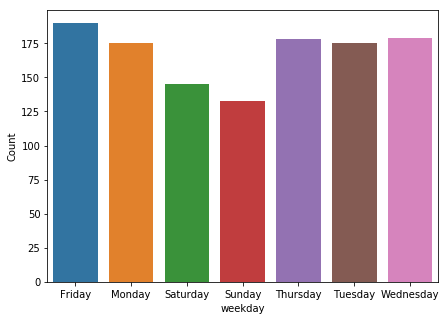

In [171]:
plt.figure(figsize=(7,5))
sns.barplot(x='weekday',y='Count',data=users_by_weekday.toPandas());

Looks like the users use sparkify more often during weekdays compared to weekend.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [172]:
#Identify a flag event

df.select('page').dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [173]:
#Define Churn

define_churn = udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())
df_churn = df.withColumn('Churn_Event',define_churn('page'))

In [174]:
user = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df_churn = df_churn.withColumn('Churn',fmax('Churn_Event').over(user))

In [175]:
df_churn.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', City='Bridgeport-Stamford-Norwalk', State=' CT', hour='12', day='08', weekday='Monday', Churn_Event=0, Churn=0)

In [176]:
# identify counts of churn vs not churn
df_churn.createOrReplaceTempView("spark_table_churn")
spark.sql("Select Churn,count(Distinct UserId) as User from spark_table_churn \
                    group by Churn").show()

+-----+----+
|Churn|User|
+-----+----+
|    1|  52|
|    0| 173|
+-----+----+



The rate of churn is about 23% of the total. 

The next step is to identify churns across different variables like Gender, Auth, location etc...

In [177]:
# Churn based on Gender
spark.sql("Select Churn,gender, count(distinct userId) from spark_table_churn group by Churn, gender").show()

+-----+------+----------------------+
|Churn|gender|count(DISTINCT userId)|
+-----+------+----------------------+
|    1|     F|                    20|
|    0|     M|                    89|
|    1|     M|                    32|
|    0|     F|                    84|
+-----+------+----------------------+



Looks like Gender doesnt seem to play a major role in churn.

In [178]:
# Churn based on Auth
spark.sql("Select Churn, Auth, count(distinct userId) from spark_table_churn group by Churn, Auth").show()

+-----+---------+----------------------+
|Churn|     Auth|count(DISTINCT userId)|
+-----+---------+----------------------+
|    1|Cancelled|                    52|
|    0|Logged In|                   173|
|    1|Logged In|                    52|
+-----+---------+----------------------+



In [179]:
# Churn based on Location
state_data = spark.sql("Select Churn, state, count (Distinct UserId) as Count \
                        from spark_table_churn group by Churn, state \
                        order by state")

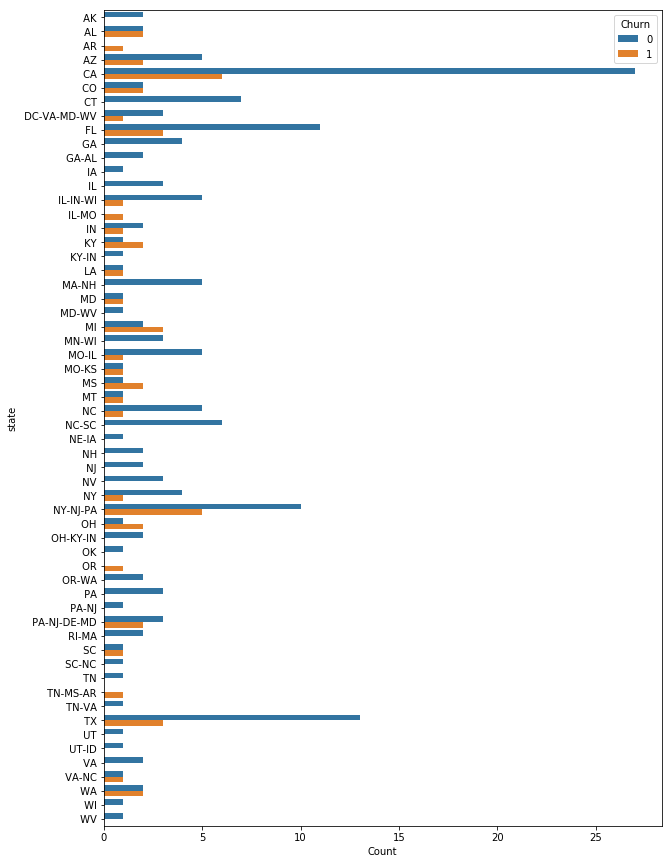

In [180]:
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot( x="Count",y="state", hue="Churn", data=state_data.toPandas(),ax=ax);

In [181]:
# Churn based on Hour 
hour_data = spark.sql ("Select Churn, hour, Count(distinct userId) as Count \
                        from spark_table_Churn group by Churn, hour \
                        order by hour")

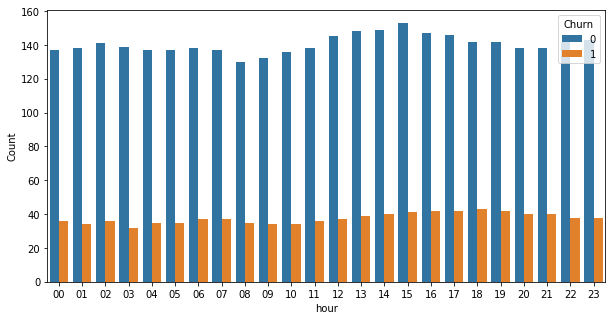

In [182]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="hour",y="Count", hue="Churn", data=hour_data.toPandas(),ax=ax);

In [183]:
# CHurn based on Day of the month
days_of_month_data = spark.sql("Select Churn, day, count(distinct userId) as Count \
                        from spark_table_churn group by churn, day \
                        order by day")

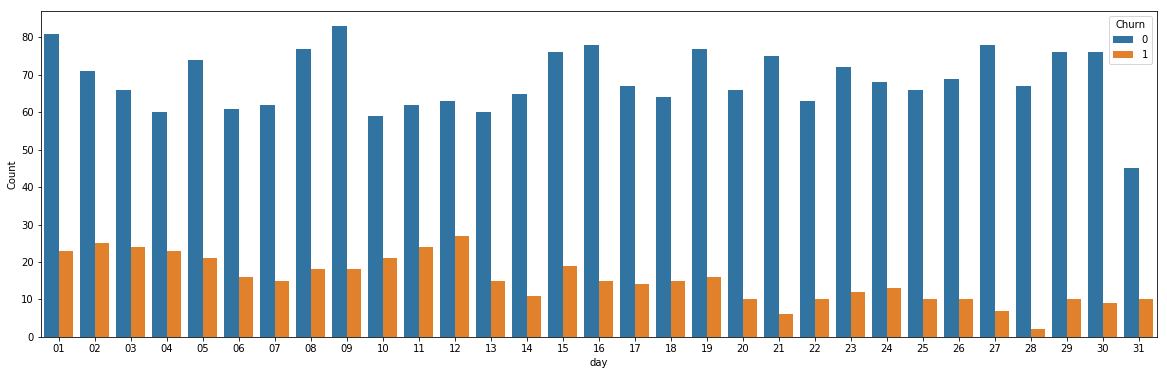

In [184]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(x="day",y="Count", hue="Churn", data=days_of_month_data.toPandas(),ax=ax);

In [185]:
# Churn based on weekday
weekday_data = spark.sql("Select Churn, weekday, count(distinct userId) as Count\
                from spark_table_churn group by Churn, weekday \
                order by weekday")

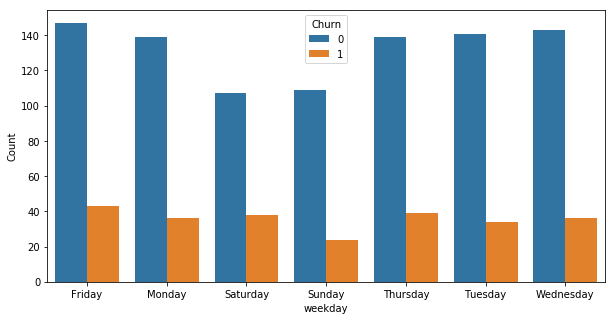

In [186]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="weekday",y="Count", hue="Churn", data=weekday_data.toPandas(),ax=ax);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [187]:
# Define feature (Categorical) based on Level (Paid Vs Free)
df_feature = spark.sql("Select main.userId, freelvl.freelevel, paidlvl.paidlevel from \
            (select distinct userId from spark_table_churn) main left outer join \
            (Select userId, level as freelevel from spark_table_churn \
            where level = 'free' group by userId, level) freelvl on \
            main.userId = freelvl.userId Left outer join \
            (Select userId, level as paidlevel from spark_table_churn \
            where level = 'paid' group by userId, level) paidlvl \
            on main.userId = paidlvl.userId")

Define few Numerical Features

In [188]:
# calculate frequency of user visits by AM/PM of the day
hourfList = []
hour_split = spark.sql("select userId,sum(case when hour between '00' and '11' Then 1 Else 0 End) as Day_AM_Count \
        ,sum(case when hour between '12' and '23' Then 1 Else 0 End) as Day_PM_Count \
        from spark_table_Churn group by userId")

for c in hour_split.columns[1:]:
    hour_dtl = hour_split.select(["userId",c])
    hourfList.append(hour_dtl)

In [189]:
# calculate frequency of user visits by First half / second half of month
monthfList = []
month_split = spark.sql("select userId,sum(case when day between '01' and '15' Then 1 Else 0 End) as FH_Mth_Count \
        ,sum(case when day > '15' Then 1 Else 0 End) as SH_Mth_Count \
        from spark_table_Churn group by userId")

for c in month_split.columns[1:]:
    month_dtl = month_split.select(["userId",c])
    monthfList.append(month_dtl)

In [190]:
# Calculate frequency of user visits by Weekdays and weekdays
weekfList = []
week_split = spark.sql("select userId,sum(case when weekday in ('Sunday','Saturday') Then 1 Else 0 End) as Weekend_Count \
        ,sum(case when weekday not in ('Sunday','Saturday') Then 1 Else 0 End) as Weekdays_Count \
        from spark_table_Churn group by userId")

for c in week_split.columns[1:]:
    week_dtl = week_split.select(["userId",c])
    weekfList.append(week_dtl)

In [191]:
# Calculate number of visits to each page by user
df_page = spark.sql("Select userId, page, count(*) as Count from spark_table_churn \
            group by userId, page")

df_page_list = df_page.groupby("userId").pivot("page").sum("Count")
page_split = df_page_list.select([col(c).alias(c.replace(' ', '_')) for c in df_page_list.columns])

In [192]:
pagefList = []
for c in page_split.columns[1:]:
    each_page = page_split.select(["userId",c])
    pagefList.append(each_page)

In [193]:
# consolidate the numerical features
numfeaturesList = []
for f in [hourfList, monthfList, weekfList, pagefList]:
    numfeaturesList.extend(f)

In [194]:
numfeaturesList

[DataFrame[userId: string, Day_AM_Count: bigint],
 DataFrame[userId: string, Day_PM_Count: bigint],
 DataFrame[userId: string, FH_Mth_Count: bigint],
 DataFrame[userId: string, SH_Mth_Count: bigint],
 DataFrame[userId: string, Weekend_Count: bigint],
 DataFrame[userId: string, Weekdays_Count: bigint],
 DataFrame[userId: string, About: bigint],
 DataFrame[userId: string, Add_Friend: bigint],
 DataFrame[userId: string, Add_to_Playlist: bigint],
 DataFrame[userId: string, Cancel: bigint],
 DataFrame[userId: string, Cancellation_Confirmation: bigint],
 DataFrame[userId: string, Downgrade: bigint],
 DataFrame[userId: string, Error: bigint],
 DataFrame[userId: string, Help: bigint],
 DataFrame[userId: string, Home: bigint],
 DataFrame[userId: string, Logout: bigint],
 DataFrame[userId: string, NextSong: bigint],
 DataFrame[userId: string, Roll_Advert: bigint],
 DataFrame[userId: string, Save_Settings: bigint],
 DataFrame[userId: string, Settings: bigint],
 DataFrame[userId: string, Submit_Do

In [195]:
# Create a new dataframe with Categorical (Level) feature and numerical feature
for f in numfeaturesList:
    df_feature = df_feature.join(f, ['userId'], how='full')

In [196]:
df_feature.show()

+------+---------+---------+------------+------------+------------+------------+-------------+--------------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|freelevel|paidlevel|Day_AM_Count|Day_PM_Count|FH_Mth_Count|SH_Mth_Count|Weekend_Count|Weekdays_Count|About|Add_Friend|Add_to_Playlist|Cancel|Cancellation_Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll_Advert|Save_Settings|Settings|Submit_Downgrade|Submit_Upgrade|Thumbs_Down|Thumbs_Up|Upgrade|
+------+---------+---------+------------+------------+------------+------------+-------------+--------------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|100010|     free|     null|         166|         215| 

In [197]:
# Check if the new dataframe has any nulls
df_feature.toPandas().isnull().sum()

userId                         0
freelevel                     30
paidlevel                     60
Day_AM_Count                   0
Day_PM_Count                   0
FH_Mth_Count                   0
SH_Mth_Count                   0
Weekend_Count                  0
Weekdays_Count                 0
About                         70
Add_Friend                    19
Add_to_Playlist               10
Cancel                       173
Cancellation_Confirmation    173
Downgrade                     71
Error                        108
Help                          33
Home                           2
Logout                        12
NextSong                       0
Roll_Advert                   18
Save_Settings                 93
Settings                      30
Submit_Downgrade             176
Submit_Upgrade                94
Thumbs_Down                   22
Thumbs_Up                      5
Upgrade                       57
dtype: int64

In [198]:
# Fill nulls with 0's on all columns except freelevel & paidlevel
df_feature = df_feature.fillna(0)

In [199]:
# Fix the null values in freelevel & paidlevel
fix_null = udf(lambda x: 1 if x else 0)
df_feature = df_feature.withColumn("freelevel", fix_null(df_feature.freelevel))
df_feature = df_feature.withColumn("paidlevel", fix_null(df_feature.paidlevel))

In [200]:
# check if all nulls have been fixed
df_feature.toPandas().isnull().sum()

userId                       0
freelevel                    0
paidlevel                    0
Day_AM_Count                 0
Day_PM_Count                 0
FH_Mth_Count                 0
SH_Mth_Count                 0
Weekend_Count                0
Weekdays_Count               0
About                        0
Add_Friend                   0
Add_to_Playlist              0
Cancel                       0
Cancellation_Confirmation    0
Downgrade                    0
Error                        0
Help                         0
Home                         0
Logout                       0
NextSong                     0
Roll_Advert                  0
Save_Settings                0
Settings                     0
Submit_Downgrade             0
Submit_Upgrade               0
Thumbs_Down                  0
Thumbs_Up                    0
Upgrade                      0
dtype: int64

In [201]:
# Define Churn based on column 'Cancellation_Confirmation'
get_churn = udf(lambda x: 1 if int(x) > 0 else 0)
df_feature = df_feature.withColumn("Churn", get_churn(df_feature.Cancellation_Confirmation))

In [202]:
df_feature.printSchema()

root
 |-- userId: string (nullable = true)
 |-- freelevel: string (nullable = true)
 |-- paidlevel: string (nullable = true)
 |-- Day_AM_Count: long (nullable = true)
 |-- Day_PM_Count: long (nullable = true)
 |-- FH_Mth_Count: long (nullable = true)
 |-- SH_Mth_Count: long (nullable = true)
 |-- Weekend_Count: long (nullable = true)
 |-- Weekdays_Count: long (nullable = true)
 |-- About: long (nullable = true)
 |-- Add_Friend: long (nullable = true)
 |-- Add_to_Playlist: long (nullable = true)
 |-- Cancel: long (nullable = true)
 |-- Cancellation_Confirmation: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll_Advert: long (nullable = true)
 |-- Save_Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit_Downgrade: long (nullable = true)
 |-- Submit_Upgrade: long

In [203]:
# convert column (except userId) datatypes to float
for c in df_feature.columns[1:]:
    df_feature = df_feature.withColumn(c, df_feature[c].cast(FloatType()))

In [204]:
# define features for classification
featurelist = df_feature.columns
featurelist.remove('userId')
featurelist.remove('Cancellation_Confirmation')
featurelist.remove('Churn')

In [205]:
# combine features using VecotrAssembler
assembler = VectorAssembler(inputCols=featurelist, outputCol="ChurnFeatures")
df_feature = assembler.transform(df_feature)

In [206]:
# scale features using Normalizer
scaler = Normalizer(inputCol="ChurnFeatures", outputCol="NormalizedChurnFeatures")
df_feature = scaler.transform(df_feature)

In [207]:
df_feature.select('userId', 'ChurnFeatures', 'NormalizedChurnFeatures').show()

+------+--------------------+-----------------------+
|userId|       ChurnFeatures|NormalizedChurnFeatures|
+------+--------------------+-----------------------+
|100010|[1.0,0.0,166.0,21...|   [0.00172650297129...|
|200002|[1.0,1.0,108.0,36...|   [0.00124932866621...|
|   125|(26,[0,2,4,7,11,1...|   (26,[0,2,4,7,11,1...|
|   124|[0.0,1.0,1974.0,2...|   [0.0,1.3015959638...|
|    51|[0.0,1.0,1177.0,1...|   [0.0,2.3695538191...|
|     7|[1.0,0.0,109.0,92...|   [0.00303435991463...|
|    15|[0.0,1.0,818.0,14...|   [0.0,2.8064100913...|
|    54|[1.0,1.0,1407.0,2...|   [1.83002544066986...|
|   155|[1.0,1.0,691.0,31...|   [6.01976596608954...|
|100014|[0.0,1.0,33.0,277...|   [0.0,0.0019256209...|
|   132|[1.0,1.0,889.0,14...|   [2.65568272156413...|
|   154|(26,[0,3,4,5,6,7,...|   (26,[0,3,4,5,6,7,...|
|   101|[1.0,1.0,1156.0,9...|   [2.72847720993037...|
|    11|[1.0,1.0,317.0,53...|   [7.55632795996455...|
|   138|[1.0,1.0,1219.0,1...|   [2.44071561822727...|
|300017|[0.0,1.0,1434.0,2...

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [208]:
data = df_feature.select(col("Churn").alias("label"), col("NormalizedChurnFeatures").alias("features"))

In [209]:
# Check for Churned vs Not churned. Not Churned is considered stayed users
users_stayed = data.filter(data.label == 0).count()
users_churned = data.filter(data.label == 1).count()

In [210]:
print("Number of stayed users in model dataset: ", users_stayed)
print("Number of churned users in model dataset: ", users_churned)
print("Percentage of stayed users in model dataset: ", users_stayed/data.count())
print("Percentage of churned users in model dataset: ", users_churned/data.count())

Number of stayed users in model dataset:  173
Number of churned users in model dataset:  52
Percentage of stayed users in model dataset:  0.7688888888888888
Percentage of churned users in model dataset:  0.2311111111111111


In [211]:
# Split into Train and Test data set
train, test = data.randomSplit([0.7, 0.3], seed=42)

In [212]:
#function to conver row obejct to string
convert_row_to_string = lambda x, y: x.asDict()[y]

In [213]:
# Define a function to evaluate model metrics
def get_metrics(model):
    tp, fp, fn, tn = [0 for i in range(4)]
    val = []
    
    label = model.select(["label"]).collect()
    prediction = model.select(["prediction"]).collect()
    labelList = list(map(convert_row_to_string, label, ['label' for i in range(len(label))]))
    predictionList = list(map(convert_row_to_string, prediction, ['prediction' for i in range(len(prediction))]))
    
    for i, (l, p) in enumerate(zip(labelList, predictionList)):    
        if (l == 1) and (p == 1):
            tp += 1
        elif (l == 0) and (p == 1):
            fp += 1
        elif (l == 1) and (p == 0):
            fn += 1
        elif (l == 0) and (p == 0):
            tn += 1
        
    val = [[tp, fp], [fn, tn]]

    accuracy = (val[0][0] + val[1][1]) / (sum(val[0]) + sum(val[1]))
    
    if val[0][0] == 0 and val[0][1] == 0 and val[1][0] == 0:
        precision, recall, f_score = [1 for i in range(3)]
    elif (val[0][0] == 0 and val[0][1] == 0) or (val[0][0] == 0 and val[1][0] == 0):
        precision, recall, f_score = [0 for i in range(3)]
    else:
        precision = val[0][0] / (val[0][0] +val[0][1])
        recall = val[0][0] / (val[0][0] + val[1][0])
        f_score = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f_score

###### Compare Different Models

In [214]:
# define evaluator to evaluate binary classification performance
evaluator = BinaryClassificationEvaluator()

###### Logistic Regression

In [215]:
clf_LR = LogisticRegression(maxIter=5)
prediction_lr = clf_LR.fit(train).transform(test)
lr_result = prediction_lr.select(['prediction', 'label'])

In [216]:
accuracy, precision, recall, f_score = get_metrics(lr_result)

print("Logistic Regression Metrics:\n")
print("Accuracy = %f" % accuracy)
print("Precison = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f_score)

Logistic Regression Metrics:

Accuracy = 0.774194
Precison = 0.555556
Recall = 0.333333
F1 Score = 0.416667


In [217]:
areaUnderROC = evaluator.evaluate(prediction_lr, {evaluator.metricName: "areaUnderROC"})
print("Test Area Under ROC is: %f" % areaUnderROC)

Test Area Under ROC is: 0.727660


###### Random Forest Classifier

In [233]:
rfc = RandomForestClassifier()
prediction_rfc = rfc.fit(train).transform(test)
rfc_result = prediction_rfc.select(['prediction', 'label'])

In [234]:
accuracy, precision, recall, f_score = get_metrics(rfc_result)

print("Random Forest Classifier Metrics:\n")
print("Accuracy = %f" % accuracy)
print("Precison = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f_score)

Random Forest Classifier Metrics:

Accuracy = 1.000000
Precison = 1.000000
Recall = 1.000000
F1 Score = 1.000000


In [235]:
areaUnderROC = evaluator.evaluate(prediction_rfc, {evaluator.metricName: "areaUnderROC"})
print("Test Area Under ROC is: %f" % areaUnderROC)

Test Area Under ROC is: 1.000000


###### Linear SVC

In [237]:
svc = LinearSVC()
prediction_svc = svc.fit(train).transform(test)
svc_result = prediction_svc.select(['prediction', 'label'])

In [238]:
accuracy, precision, recall, f_score = get_metrics(svc_result)

print("Linear SVC Metrics:\n")
print("Accuracy = %f" % accuracy)
print("Precison = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f_score)

Linear SVC Metrics:

Accuracy = 1.000000
Precison = 1.000000
Recall = 1.000000
F1 Score = 1.000000


In [239]:
areaUnderROC = evaluator.evaluate(prediction_svc, {evaluator.metricName: "areaUnderROC"})
print("Test Area Under ROC is: %f" % areaUnderROC)

Test Area Under ROC is: 1.000000


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.